# 1.建立数据库

In [ ]:
import sqlite3
import pandas as pd

# 创建数据库连接
conn = sqlite3.connect('nomis_data.db')

# TSV文件和对应的表名
tsv_files = {
    # 'D:/Dissertation/project/data/observational data/1annual population survey/SOC2010_21370851878959376_data.tsv': 'SOC2010_employmentpercent',
    # 'D:/Dissertation/project/data/observational data/1annual population survey/SOC2020_21354692132373544_data.tsv': 'SOC2020_employmentpercent',
    # 'D:/Dissertation/project/data/observational data/2annual population survey/21363951043487306_data.tsv': 'un_employment_qualification_byage',
    # 'D:/Dissertation/project/data/observational data/3annual survey of hours and earnings - workplace analysis/5331161679142277_data.tsv': 'pay_time_weekly',
    'D:/Dissertation/project/data/observational data/4RM011 - Country of birth by age/23825931246572534_data.tsv': 'population_byage',
    # 'D:/Dissertation/project/data/observational data/5RM016 - Distance travelled to work by occupation/21386281053368857_data.tsv': 'commute_byoccupation',
    # 'D:/Dissertation/project/data/observational data/6TS060 - Industry/23831791361490009_data.tsv':'population_industry',
    # 'D:/Dissertation/project/data/observational data/1annual population survey/SOC2010_sub_640423263229051_data.tsv':'SOC2010_sub',
    # 'D:/Dissertation/project/data/observational data/1annual population survey/SOC2020_sub_22371061404360831.tsv':'SOC2020_sub'
}


for tsv_file, table_name in tsv_files.items():
    try:
        # 读取TSV文件
        df = pd.read_csv(tsv_file, sep='\t')
        
        # 导入到SQLite
        df.to_sql(table_name, conn, if_exists='replace', index=False)
        
        print(f"成功导入 {len(df)} 行到表 {table_name}")
    except Exception as e:
        print(f"处理文件 {tsv_file} 时出错: {e}")

conn.close()

## 数据清洗-修改表格式

在SOC1020——combined表中添加London---E09000001数据

In [ ]:
import sqlite3
import pandas as pd

# 步骤1：定义输入数据
data = {
    'geogcode': ['E09000001'] * 108,  # 9 variables * 12 years
    'variable': [str(v) for v in range(1, 10)] * 12,
    'year': [y for y in range(2013, 2025) for _ in range(9)],
    'value': [
        11.4, 24.9, 17.5, 10.4, 7.7, 7.7, 6.8, 4.0, 8.8,  # 2013
        11.8, 23.7, 18.0, 10.6, 7.5, 7.4, 6.7, 4.2, 9.3,  # 2014
        11.7, 24.0, 17.2, 10.0, 7.7, 8.1, 6.8, 4.4, 9.7,  # 2015
        12.4, 25.2, 17.9, 9.2, 7.0, 7.5, 6.7, 4.7, 9.0,   # 2016
        12.4, 25.6, 17.4, 9.7, 7.5, 7.1, 6.7, 4.4, 8.8,   # 2017
        12.3, 26.2, 18.5, 9.5, 6.9, 7.2, 5.9, 4.4, 8.5,   # 2018
        13.5, 26.5, 18.3, 8.7, 7.0, 7.1, 5.8, 4.5, 8.0,   # 2019
        13.3, 29.8, 19.2, 9.3, 6.0, 6.7, 5.3, 3.4, 6.4,   # 2020
        12.6, 30.5, 18.5, 10.0, 5.2, 7.1, 5.5, 3.2, 6.8,  # 2021
        12.8, 33.6, 16.2, 8.9, 6.3, 7.0, 5.0, 3.2, 6.5,   # 2022
        13.1, 33.2, 16.9, 8.9, 6.0, 6.5, 5.5, 3.2, 6.6,   # 2023
        13.9, 33.7, 17.1, 8.0, 5.5, 6.9, 4.7, 3.3, 6.7    # 2024
    ]
}
df = pd.DataFrame(data)

# 步骤2：连接数据库
conn = sqlite3.connect('nomis_data.db')
cursor = conn.cursor()

# 创建表（如果不存在）
cursor.execute("""
CREATE TABLE IF NOT EXISTS SOC1020_combined (
    geogcode TEXT,
    year INTEGER,
    variable TEXT,
    value REAL,
    PRIMARY KEY (geogcode, year, variable)
)
""")

# 步骤3：删除geogcode='E09000001'的现有记录
cursor.execute("DELETE FROM SOC1020_combined WHERE geogcode = 'E09000001'")

# 步骤4：插入新数据
df.to_sql('SOC1020_combined', conn, if_exists='append', index=False)

# 步骤5：提交更改并关闭连接
conn.commit()
conn.close()

print("已删除E09000001的原有记录并添加新数据到SOC1020_combined表")

对SOC1020_combined进行插值补充

In [ ]:
import sqlite3
import pandas as pd
import numpy as np

# 连接数据库
conn = sqlite3.connect('nomis_data.db')
cursor = conn.cursor()

# 步骤1：读取SOC1020_combined表数据
query = """
SELECT geogcode, year, variable, value
FROM SOC1020_combined
"""
df = pd.read_sql_query(query, conn)

# 步骤2：定义插值和误差计算函数
def interpolate_and_compute_error(group):
    # 提取年份和值
    years = group['year'].values
    values = group['value'].values
    
    # 标记空值或0值的位置
    mask = (pd.isna(values) | (values == 0))
    
    # 初始化MSE
    mse = 0.0
    
    if mask.all():
        # 如果全为0或空值，填充为0，MSE为0
        group['value'] = group['value'].fillna(0)
        return group, mse
    
    # 获取非空、非0的数据点
    valid_mask = ~mask
    valid_years = years[valid_mask]
    valid_values = values[valid_mask]
    
    if len(valid_values) >= 3:
        # 拟合2阶多项式
        try:
            coeffs = np.polyfit(valid_years, valid_values, deg=2)
            poly = np.poly1d(coeffs)
            # 对空值或0值插值
            group.loc[mask, 'value'] = poly(years[mask])
            # 严格限制在[0, 60]
            group['value'] = np.clip(group['value'], 0, 60)
            # 计算MSE（仅针对有效点）
            predicted_values = np.clip(poly(valid_years), 0, 60)
            mse = np.mean((valid_values - predicted_values) ** 2)
        except np.linalg.LinAlgError:
            # 如果多项式拟合失败，切换到线性插值
            group['value'] = group['value'].interpolate(method='linear', limit_direction='both')
            group['value'] = np.clip(group['value'], 0, 60)
            group['value'] = group['value'].fillna(group['value'].mean())
            group['value'] = np.clip(group['value'], 0, 60)
            if len(valid_values) > 0:
                valid_indices = group.index[valid_mask]
                predicted_values = group.loc[valid_indices, 'value']
                mse = np.mean((valid_values - predicted_values) ** 2)
    else:
        # 使用线性插值
        group['value'] = group['value'].interpolate(method='linear', limit_direction='both')
        # 填充剩余NaN
        group['value'] = group['value'].fillna(group['value'].mean())
        # 严格限制在[0, 60]
        group['value'] = np.clip(group['value'], 0, 60)
        # 如果有有效点，计算MSE
        if len(valid_values) > 0:
            valid_indices = group.index[valid_mask]
            predicted_values = group.loc[valid_indices, 'value']
            mse = np.mean((valid_values - predicted_values) ** 2)
    
    # 额外检查负值
    if (group['value'] < 0).any():
        print(f"警告：组(geogcode={group['geogcode'].iloc[0]}, variable={group['variable'].iloc[0]}) "
              f"包含负值，已强制设为0")
        group['value'] = np.clip(group['value'], 0, 60)
    
    return group, mse

# 步骤3：按geogcode和variable分组，应用插值并收集误差
results = []
errors = []
for (geogcode, variable), group in df.groupby(['geogcode', 'variable']):
    interpolated_group, mse = interpolate_and_compute_error(group.copy())
    results.append(interpolated_group)
    errors.append({'geogcode': geogcode, 'variable': variable, 'mse': mse})

# 合并插值结果
interpolated_df = pd.concat(results).reset_index(drop=True)
# 创建误差DataFrame
errors_df = pd.DataFrame(errors)

# 步骤4：检查负值
if (interpolated_df['value'] < 0).any():
    print("警告：插值结果中仍包含负值，已强制设为0")
    interpolated_df['value'] = np.clip(interpolated_df['value'], 0, 60)

# 步骤5：保存插值结果到SOC1020_combined_interpolated表
cursor.execute("DROP TABLE IF EXISTS SOC1020_combined_interpolated")
interpolated_df.to_sql('SOC1020_combined_interpolated', conn, index=False, if_exists='replace')

# 步骤7：打印误差结果
print("插值误差（均方误差，MSE）：")
print(errors_df)

# 步骤8：提交更改并关闭连接
conn.commit()
conn.close()

print("/n插值完成，结果已保存到SOC1020_combined_interpolated表")
print("误差已保存到interpolation_errors表")

E06000053和E09000001缺失数据太多，不再进行后续分析

soc2010_sub和soc2020_sub合并

In [ ]:
import pandas as pd
import sqlite3

# 连接数据库并读取数据
conn = sqlite3.connect("nomis_data.db")
soc2010 = pd.read_sql("SELECT * FROM SOC2010_sub_cleaned", conn)
soc2020 = pd.read_sql("SELECT * FROM SOC2020_sub_cleaned", conn)

# 合并两个表，SOC2010保持不变
soc1020 = pd.concat([soc2010, soc2020], ignore_index=True)

# 数据清洗：确保year列是整数类型，value列是数值类型
soc1020['year'] = pd.to_numeric(soc1020['year'], errors='coerce').fillna(0).astype(int)
soc1020['value'] = pd.to_numeric(soc1020['value'], errors='coerce').fillna(0)

# 对SOC2020数据进行修改（只修改2020及以后的数据）
soc2020_data = soc1020[soc1020['year'] >= 2020].copy()

# 按geogcode、variable和year分组
grouped = soc2020_data.groupby(['geogcode', 'variable', 'year'])

def safe_float_conversion(x):
    """安全转换为float的函数"""
    try:
        return float(x)
    except (ValueError, TypeError):
        return 0.0

def get_value(df, geogcode, variable, year):
    """安全获取特定条件的value值"""
    filtered = df[(df['geogcode'] == geogcode) & 
                 (df['variable'] == variable) &
                 (df['year'] == year)]
    return safe_float_conversion(filtered['value'].iloc[0]) if not filtered.empty else 0.0

def modify_values(group):
    """修改值的函数，增加了错误处理"""
    try:
        geogcode, variable, year = group.name
        
        # 获取当前组的值
        current_val = safe_float_conversion(group['value'].iloc[0]) if not group.empty else 0.0
        
        # 根据variable类型应用不同的修改公式
        if variable == 12:
            val_62 = get_value(soc2020_data, geogcode, 62, year)
            val_71 = get_value(soc2020_data, geogcode, 71, year)
            new_value = current_val * 0.82 + val_62 * 0.01 + val_71 * 0.17
            
        elif variable == 32:
            val_22 = get_value(soc2020_data, geogcode, 22, year)
            val_61 = get_value(soc2020_data, geogcode, 61, year)
            new_value = val_22 * 0.07 + current_val * 0.92 + val_61 * 0.01
            
        elif variable == 33:
            val_63 = get_value(soc2020_data, geogcode, 63, year)
            new_value = current_val * 0.94 + val_63 * 0.06
            
        elif variable == 34:
            val_21 = get_value(soc2020_data, geogcode, 21, year)
            new_value = current_val * 0.86 + val_21 * 0.14
            
        elif variable == 35:
            val_24 = get_value(soc2020_data, geogcode, 24, year)
            new_value = current_val * 0.85 + val_24 * 0.15
            
        elif variable == 42:
            val_41 = get_value(soc2020_data, geogcode, 41, year)
            val_31 = get_value(soc2020_data, geogcode, 31, year)
            new_value = current_val * 0.83 + val_41 * 0.15 + val_31 * 0.02
            
        elif variable == 61:
            val_32 = get_value(soc2020_data, geogcode, 32, year)
            new_value = current_val * 0.95 + val_32 * 0.05
            
        elif variable == 72:
            val_41 = get_value(soc2020_data, geogcode, 41, year)
            new_value = current_val * 0.85 + val_41 * 0.15
            
        else:
            new_value = current_val  # 不满足条件的变量保持原值
            
        group['value'] = new_value
        
    except Exception as e:
        print(f"处理组 {group.name} 时出错: {str(e)}")
        group['value'] = 0.0  # 出错时设为默认值
        
    return group

# 应用修改函数
modified_soc2020 = grouped.apply(modify_values).reset_index(drop=True)

# 将修改后的SOC2020数据与未修改的SOC2010数据合并
soc2010_data = soc1020[soc1020['year'] < 2020]
final_soc1020 = pd.concat([soc2010_data, modified_soc2020], ignore_index=True)
final_soc1020.to_sql('SOC1020_sub_combined', conn, if_exists='replace', index=False)

# 保存结果
final_soc1020.to_csv('SOC1020_sub.csv', index=False)

对SOC1020_sub_combined插值补充

In [ ]:
import sqlite3
# 连接数据库
conn = sqlite3.connect("nomis_data.db")
cursor = conn.cursor()
cursor.execute("DROP TABLE population_industy")
conn.close()

(按照2013-2024年统计数据进行多项式插值补充)

In [ ]:
import sqlite3
import pandas as pd
import numpy as np

# 连接到 SQLite 数据库
conn = sqlite3.connect('nomis_data.db')

# 加载 SOC1020_sub_combined 表
df = pd.read_sql_query("SELECT * FROM SOC1020_sub_combined", conn)

# 确保 'value' 列为数值型，非数值转为 NaN
df['value'] = pd.to_numeric(df['value'], errors='coerce')

# 第一步：对 2024 年的空值进行多项式插值
# 创建插值表的副本
df_interpolated = df.copy()

# 按 geogcode 和 variable 分组，进行多项式插值
def polynomial_interpolate_group(group, degree=2):
    # 按年份排序，确保时间顺序
    group = group.sort_values('year')
    # 去除 NaN 值以拟合多项式
    valid = group.dropna(subset=['value'])
    if len(valid) < degree + 1:
        # 如果数据点不足，无法拟合多项式，使用线性插值作为备用
        group['value'] = group['value'].interpolate(method='linear', limit_direction='both')
    else:
        # 使用 numpy.polyfit 拟合多项式
        poly_coeffs = np.polyfit(valid['year'], valid['value'], degree)
        poly_func = np.poly1d(poly_coeffs)
        # 对整个组的 year 计算 value，包括缺失值
        group['value'] = poly_func(group['year'])
    # 限制值在 [0, 30] 范围内
    group['value'] = group['value'].clip(lower=0, upper=30)
    return group

# 应用多项式插值
df_interpolated = df_interpolated.groupby(['geogcode', 'variable']).apply(lambda g: polynomial_interpolate_group(g, degree=2)).reset_index(drop=True)

# 将插值结果保存到新表
df_interpolated.to_sql('SOC1020_sub_combined_interpolated', conn, if_exists='replace', index=False)

# 计算插值误差：对于有原始数据的点，计算拟合值与原始值的均方误差 (MSE)
error_df = df.copy()
error_df = error_df.merge(df_interpolated, on=['geogcode', 'year', 'variable'], suffixes=('_original', '_interpolated'))
error_df['error'] = (error_df['value_original'] - error_df['value_interpolated']) ** 2
error_df = error_df.dropna(subset=['value_original'])  # 只计算有原始数据的点

# 计算总体 MSE
mse = error_df['error'].mean()

# 计算每个 geogcode 的 MSE
mse_by_geogcode = error_df.groupby('geogcode')['error'].mean().reset_index()
mse_by_geogcode.columns = ['geogcode', 'mse']

# 打印总体 MSE
print("\n总体均方误差 (MSE):")
print(mse)

# 打印每个地区的 MSE
print("\n每个地区的均方误差 (MSE):")
print(mse_by_geogcode)

# 第二步：计算 2024 年每个地区的就业比例总和
df_2024_interpolated = df_interpolated[df_interpolated['year'] == 2024]
sum_by_region = df_2024_interpolated.groupby('geogcode')['value'].sum().reset_index()
sum_by_region.columns = ['geogcode', 'total_employment_proportion']

# 打印每个地区的总和
print("\n2024 年每个地区的就业比例总和：")
print(sum_by_region)

# 第三步：处理 2024 年仍为空值或为 0 的数据
# 找出 value 为空或为 0 的记录
df_2024_missing = df_2024_interpolated[df_2024_interpolated['value'].isna() | (df_2024_interpolated['value'] == 0)]
missing_counts = df_2024_missing.groupby('geogcode').size().reset_index(name='missing_count')

# 筛选只有单一空值或零值的地区
single_missing_regions = missing_counts[missing_counts['missing_count'] == 1]['geogcode']

# 处理单一空值或零值的地区
for region in single_missing_regions:
    # 获取该地区 2024 年的所有数据
    region_data = df_2024_interpolated[df_2024_interpolated['geogcode'] == region]
    # 计算非空且非零值的总和
    valid_values = region_data[region_data['value'].notna() & (region_data['value'] != 0)]['value']
    total_valid = valid_values.sum()
    # 如果总和小于 100，设置空值或零值为 100 - 总和
    if total_valid < 100:
        # 找到空值或零值的行
        missing_row = region_data[region_data['value'].isna() | (region_data['value'] == 0)]
        if not missing_row.empty:
            # 计算新值，限制在 [0, 30]
            new_value = min(max(100 - total_valid, 0), 30)
            # 更新 df_interpolated 中的值
            df_interpolated.loc[
                (df_interpolated['geogcode'] == region) &
                (df_interpolated['year'] == 2024) &
                (df_interpolated['variable'] == missing_row['variable'].iloc[0]),
                'value'
            ] = new_value

# 将更新后的插值表保存回数据库
df_interpolated.to_sql('SOC1020_sub_combined_interpolated', conn, if_exists='replace', index=False)

# 重新计算并打印最终的 2024 年各地区就业比例总和
df_2024_final = df_interpolated[df_interpolated['year'] == 2024]
final_sum_by_region = df_2024_final.groupby('geogcode')['value'].sum().reset_index()
final_sum_by_region.columns = ['geogcode', 'total_employment_proportion']

print("\n处理单一空值后的 2024 年各地区就业比例总和：")
print(final_sum_by_region)

# 检查仍为空值或为 0 的数据
remaining_issues = df_2024_final[df_2024_final['value'].isna() | (df_2024_final['value'] == 0)]
if not remaining_issues.empty:
    print("\n2024 年仍存在空值或零值的记录：")
    print(remaining_issues[['geogcode', 'year', 'variable', 'value']])
else:
    print("\n2024 年没有剩余的空值或零值。")

# 关闭数据库连接
conn.close()

(按照2024年Column Total比例进行补充)

In [ ]:
import sqlite3
import pandas as pd

# 连接到数据库
conn = sqlite3.connect('nomis_data.db')
cursor = conn.cursor()

# 步骤1：获取2024年Column Total的基准数据
query_column_total = """
SELECT variable, value
FROM SOC1020_sub_combined_interpolated
WHERE year = 2024 AND geogcode = 'Column Total'
"""
column_total_df = pd.read_sql_query(query_column_total, conn)

# 步骤2：获取2024年非Column Total的地区数据
query_region_data = """
SELECT geogcode, variable, COALESCE(value, 0) AS value
FROM SOC1020_sub_combined_interpolated
WHERE year = 2024 AND geogcode != 'Column Total'
"""
region_data_df = pd.read_sql_query(query_region_data, conn)

# 步骤3：补全缺失的variable
# 获取所有地区和所有可能的variable（从Column Total）
all_geogcodes = region_data_df['geogcode'].unique()
all_variables = column_total_df['variable'].unique()

# 创建所有geogcode和variable的组合
all_combinations = pd.MultiIndex.from_product(
    [all_geogcodes, all_variables], names=['geogcode', 'variable']
).to_frame(index=False)

# 合并region_data_df和all_combinations
region_data_df = all_combinations.merge(
    region_data_df, on=['geogcode', 'variable'], how='left'
)

# 步骤4：替换空值或0值为Column Total的基准值
# 合并Column Total的value
region_data_df = region_data_df.merge(
    column_total_df[['variable', 'value']], on='variable', how='left', suffixes=('', '_ref')
)
# 填充空值或0值
region_data_df['value'] = region_data_df.apply(
    lambda row: row['value_ref'] if pd.isna(row['value']) or row['value'] == 0 else row['value'],
    axis=1
)
# 删除临时的value_ref列
region_data_df = region_data_df.drop(columns=['value_ref'])

# 步骤5：归一化处理，确保每个地区value之和为100
# 计算每个地区的value总和
region_data_df['total_value'] = region_data_df.groupby('geogcode')['value'].transform('sum')
# 归一化value
region_data_df['normalized_value'] = region_data_df['value'] * 100.0 / region_data_df['total_value']
# 删除临时列
region_data_df = region_data_df.drop(columns=['value', 'total_value'])

# 步骤6：添加year列并重命名
region_data_df['year'] = 2024
region_data_df = region_data_df.rename(columns={'normalized_value': 'value'})

# 步骤7：保存结果到新表SOC1020_sub_combined_interpolated_2024
# 写入新表
#cursor.execute("DROP TABLE IF EXISTS SOC1020_sub_combined_2024")
region_data_df[['geogcode', 'year', 'variable', 'value']].to_sql(
    'SOC1020_sub_combined_interpolated_2024', conn, index=False, if_exists='replace'
)

# 提交更改并关闭连接
conn.commit()
conn.close()

print("处理完成，结果已保存到SOC1020_sub_combined_interpolated_2024表")

清理其他自变量数据

整理数据库nomis_data.db中的以下表格，输出表格都在原表名后面添加_cleaned:
1.commute_byoccupation_cleaned：按照Distance travelled to wor和geogcode分类，仅保留Occupation(current)中Total对应的value数据，输出Distance travelled to wor、geogcode、Date、value字段。
2.pay_time_weekly_cleaned:保留value type字段为number的部分，除了Confidence和value type字段删掉，其他字段都保留。
3.population_industry:保留value type字段为number的部分，除了Confidence、flag、Units、Population、value type字段删掉，其他字段都保留。
4.un_employment_qualification_byage：保留value type字段为percent的部分,除了Confidence、flag、value type字段删掉，其他字段都保留。

In [ ]:
import sqlite3
import pandas as pd

# 连接数据库
conn = sqlite3.connect('nomis_data.db')
cursor = conn.cursor()

# 1. 处理 commute_byoccupation
query_commute = """
SELECT "Distance travelled to wor", geogcode, Date, value
FROM commute_byoccupation
WHERE "Occupation (current)" = 'Total'
"""
commute_df = pd.read_sql_query(query_commute, conn)
cursor.execute("DROP TABLE IF EXISTS commute_byoccupation_cleaned")
commute_df.to_sql('commute_byoccupation_cleaned', conn, index=False, if_exists='replace')

# 2. 处理 pay_time_weekly
query_pay = """
SELECT *
FROM pay_time_weekly
WHERE "value type" = 'number'
"""
pay_df = pd.read_sql_query(query_pay, conn)
# 删除 Confidence 和 value type 字段
pay_df = pay_df.drop(columns=['Confidence','Sex', 'Item Name', 'value type', 'flag'], errors='ignore')
cursor.execute("DROP TABLE IF EXISTS pay_time_weekly_cleaned")
pay_df.to_sql('pay_time_weekly_cleaned', conn, index=False, if_exists='replace')

# 3. 处理 population_industry
query_pop = """
SELECT *
FROM population_industry
WHERE "value type" = '%'
AND "Industry (current)" != 'Total: All usual residents aged 16 years and over in employment the week before the census'
"""
pop_df = pd.read_sql_query(query_pop, conn)
# 删除 Confidence, flag, Units, Population, value type 字段
pop_df = pop_df.drop(columns=['Confidence', 'flag', 'Units', 'Population', 'value type'], errors='ignore')
cursor.execute("DROP TABLE IF EXISTS population_industry_cleaned")
pop_df.to_sql('population_industry_cleaned', conn, index=False, if_exists='replace')

# 4. 处理 un_employment_qualification_byage
query_unemp = """
SELECT *
FROM un_employment_qualification_byage
WHERE "value type" = 'Percent'
"""
unemp_df = pd.read_sql_query(query_unemp, conn)
# 删除 Confidence, flag, value type 字段
unemp_df = unemp_df.drop(columns=['Confidence', 'flag', 'value type'], errors='ignore')
cursor.execute("DROP TABLE IF EXISTS un_employment_qualification_byage_cleaned")
unemp_df.to_sql('un_employment_qualification_byage_cleaned', conn, index=False, if_exists='replace')

#5. 处理 population_byage
# 将population_byage表加载到DataFrame
popa_df = pd.read_sql_query("SELECT * FROM population_byage", conn)

# 透视数据，将“Total”和其他年龄组作为列
pivot_df = popa_df.pivot_table(
    index=['geogcode', 'Date'],
    columns='Age',
    values='value',
    aggfunc='sum'
).reset_index()
# 计算非“Total”年龄组的百分比
age_columns = [col for col in pivot_df.columns if col not in ['geogcode', 'Date', 'Total']]
for col in age_columns:
    pivot_df[col] = (pivot_df[col] / pivot_df['Total'] * 100).round(2)
# 将DataFrame转换回长格式
cleaned_popa_df = pivot_df.melt(
    id_vars=['geogcode', 'Date'],
    value_vars=age_columns,
    var_name='Age',
    value_name='value'
)
# 删除value为NaN的行
cleaned_popa_df = cleaned_popa_df.dropna(subset=['value'])
# 创建清理后的表
cursor.execute("DROP TABLE IF EXISTS population_byage_cleaned")
cleaned_popa_df.to_sql('population_byage_cleaned', conn, index=False)

#6. 处理 population_byage
# 将 population_byage 表加载到 DataFrame，仅选择指定字段
pop_dis_df = pd.read_sql_query(
    "SELECT geogcode, Date, Age, value FROM population_byage WHERE Age = 'Total'",conn)
# 将清洗后的 DataFrame 保存到 population_distirct_cleaned 表
pop_dis_df.to_sql('population_distirct_cleaned', conn, index=False, if_exists='replace')

# 提交更改并关闭连接
conn.commit()
conn.close()

print("所有表格处理完成，结果已保存到以下新表：")
print("- commute_byoccupation_cleaned")
print("- pay_time_weekly_cleaned")
print("- population_industry_cleaned")
print("- un_employment_qualification_byage_cleaned")
print("- population_byage_cleaned")
print("- population_distirct_cleaned")

In [ ]:
import sqlite3
import pandas as pd

# 连接数据库
conn = sqlite3.connect('nomis_data.db')
cursor = conn.cursor()

# 1. 处理 pay_time_weekly_cleaned
query_pay = """
SELECT *
FROM pay_time_weekly_cleaned
"""
pay_df = pd.read_sql_query(query_pay, conn)

# 1.1 拆分为 pay_weekly_cleaned (Weekly pay - gross)
pay_weekly_df = pay_df[pay_df['pay'] == 'Weekly pay - gross']
cursor.execute("DROP TABLE IF EXISTS pay_weekly_cleaned")
pay_weekly_df.to_sql('pay_weekly_cleaned', conn, index=False, if_exists='replace')

# 1.2 拆分为 hours_weekly_cleaned (Hours worked - total)
hours_weekly_df = pay_df[pay_df['pay'] == 'Hours worked - total']
cursor.execute("DROP TABLE IF EXISTS hours_weekly_cleaned")
hours_weekly_df.to_sql('hours_weekly_cleaned', conn, index=False, if_exists='replace')

# 2. 处理 un_employment_qualification_byage_cleaned
query_unemp = """
SELECT *
FROM un_employment_qualification_byage_cleaned
"""
unemp_df = pd.read_sql_query(query_unemp, conn)

# 2.1 拆分为 self_employment_cleaned (% aged 16-64 who are self employed)
self_emp_df = unemp_df[unemp_df['variable'] == '% aged 16-64 who are self employed']
cursor.execute("DROP TABLE IF EXISTS self_employment_cleaned")
self_emp_df.to_sql('self_employment_cleaned', conn, index=False, if_exists='replace')

# 2.3 拆分为 qualification_cleaned (RQF1+ to RQF4+)
qualification_vars = [
    '% with RQF4+ - aged 16-64',
    '% with RQF3+ - aged 16-64',
    '% with RQF2+ - aged 16-64',
    '% with RQF1+ - aged 16-64'
]
qual_df = unemp_df[unemp_df['variable'].isin(qualification_vars)]
cursor.execute("DROP TABLE IF EXISTS qualification_cleaned")
qual_df.to_sql('qualification_cleaned', conn, index=False, if_exists='replace')

# 提交更改并关闭连接
conn.commit()
conn.close()

print("表格拆分完成，结果已保存到以下新表：")
print("- pay_weekly_cleaned")
print("- hours_weekly_cleaned")
print("- self_employment_cleaned")
print("- qualification_cleaned")

# 2.计算指标

## 1.计算JPI

In [ ]:
import sqlite3
import pandas as pd

# Connect to the SQLite database
conn = sqlite3.connect('nomis_data.db')

# Query to categorize and sum values by high, median, low
query = """
SELECT 
    geogcode,
    year,
    SUM(CASE WHEN variable IN ('1', '2', '3') THEN value ELSE 0 END) as high_sum,
    SUM(CASE WHEN variable IN ('8', '9') THEN value ELSE 0 END) as low_sum,
    SUM(CASE WHEN variable NOT IN ('1', '2', '3', '8', '9') THEN value ELSE 0 END) as median_sum
FROM SOC1020_combined_interpolated
GROUP BY geogcode, year
"""

# Load data into a DataFrame
df = pd.read_sql_query(query, conn)

# Calculate h_change and l_change
changes = df.groupby('geogcode').apply(
    lambda x: pd.Series({
        'h_change': x[x['year'] == 2024]['high_sum'].iloc[0] - x[(x['year'] >= 2019) & (x['year'] <= 2023)]['high_sum'].mean(),
        'l_change': x[x['year'] == 2024]['low_sum'].iloc[0] - x[(x['year'] >= 2019) & (x['year'] <= 2023)]['low_sum'].mean()
    })
).reset_index()

# Calculate JPI
changes['JPI'] = (changes['h_change'] + changes['l_change']) * (1 + abs(changes['h_change'] - changes['l_change'])) * 0.5 * 0.01

# Select relevant columns
result = changes[['geogcode', 'h_change', 'l_change', 'JPI']].sort_values('geogcode')

# Create new table employment_JPI
result.to_sql('employment_JPI', conn, if_exists='replace', index=False)

# Close the connection
conn.close()

## 2.计算AI暴露度

In [72]:
import sqlite3
import pandas as pd

# 步骤1：定义AI暴露指数表
ai_exposure_data = {
    'SOC2010_sub_map': [
        '11', '12', '21', '22', '23', '24', '31', '32', '33', '34', '35', '41', '42',
        '51', '52', '53', '54', '61', '62', '71', '81', '82', '91', '92'
    ],
    'Average_AI_Exposure': [
        0.6302, 0.3593, 0.9020, 0.4754, 0.7698, 0.8288, 0.9478, 0.5080, 0.2940, 0.5338,
        0.7494, 0.5630, 0.8065, 0.5196, 0.4529, 0.1760, 0.3752, 0.2880, 0.2017, 0.0880,
        0.3674, 0.2720, 0.1260, 0.0293
    ]
}
ai_exposure_df = pd.DataFrame(ai_exposure_data)

# 步骤2：连接数据库并读取2024年数据
conn = sqlite3.connect('nomis_data.db')
query = """
SELECT geogcode, variable, value
FROM SOC1020_sub_combined_interpolated_2024
WHERE year = 2024
"""
data_df = pd.read_sql_query(query, conn)

# 步骤3：合并AI暴露指数
merged_df = data_df.merge(ai_exposure_df, left_on='variable', right_on='SOC2010_sub_map', how='left')

# 步骤4：计算每个geogcode的加权平均AI暴露指数
# 计算value * AI_exposure
merged_df['weighted_exposure'] = merged_df['value'] * merged_df['Average_AI_Exposure']
# 按geogcode分组，计算加权平均
result_df = merged_df.groupby('geogcode').agg({
    'weighted_exposure': 'sum',
    'value': 'sum'
}).reset_index()
# 计算平均AI暴露指数（value已归一化为100，无需除以sum(value)）
result_df['avg_ai_exposure'] = result_df['weighted_exposure'] / 100.0
# 选择所需列
result_df = result_df[['geogcode', 'avg_ai_exposure']]

# 步骤5：保存结果到新表
cursor = conn.cursor()
#cursor.execute("DROP TABLE IF EXISTS interpolation_report")
result_df.to_sql('AI_avg_exposure_2024', conn, index=False, if_exists='replace')

# 提交更改并关闭连接
conn.commit()
conn.close()

print("处理完成，结果已保存到AI_avg_exposure_2024表")

处理完成，结果已保存到AI_avg_exposure_2024表


In [73]:
#修改'E06000053'与'E09000001'，来自SAR模型预测

import sqlite3

# 定义SQL更新语句
update_sql = """
UPDATE AI_avg_exposure_2024
SET avg_ai_exposure = CASE 
    WHEN geogcode = 'E06000053' THEN 0.39070763190780466
    WHEN geogcode = 'E09000001' THEN 0.6101811901686062
    ELSE avg_ai_exposure
END
WHERE geogcode IN ('E06000053', 'E09000001');
"""

try:
    # 执行SQL语句
    conn = sqlite3.connect('nomis_data.db')
    cursor = conn.cursor()
    cursor.executescript(update_sql)  # 使用executescript执行多行SQL
    conn.commit()
    print("AI_avg_exposure_2024已更新")
    
except sqlite3.Error as e:
    print(f"数据库错误: {e}")
finally:
    if conn:
        conn.close()


AI_avg_exposure_2024已更新


### 数据准备ols_data_2024

In [24]:
import sqlite3
import pandas as pd

# 连接到数据库
conn = sqlite3.connect('nomis_data.db')
cursor = conn.cursor()

# 列出所有需要处理的表格
tables = [
    'commute_byoccupation_cleaned',
    'population_industry_cleaned',
    'pay_weekly_cleaned',
    'hours_weekly_cleaned',
    'self_employment_cleaned',
    'qualification_cleaned',
    'population_byage_cleaned'
]

# 加载Al_avg_exposure_2024表
base_df1 = pd.read_sql_query("SELECT * FROM AI_avg_exposure_2024", conn)
base_df2 = pd.read_sql_query("SELECT * FROM employment_JPI", conn)
#population_distirct_cleaned
base_df3 = pd.read_sql_query("SELECT * FROM population_distirct_cleaned", conn)
base_df3 = base_df3.rename(columns={'value': 'population_total'})

# 初始化结果DataFrame，仅包含geogcode
result_df = base_df1

# 对每个表格进行处理
for table in tables:
    # 加载表格
    df = pd.read_sql_query(f"SELECT * FROM {table}", conn)
    
    # 获取分类列（排除geogcode和date）
    category_cols = [col for col in df.columns if col not in ['geogcode', 'Date', 'value']]
    
    if category_cols:
        # 假设只有一个分类列
        category_col = category_cols[0]
        # 透视表格
        pivot_df = df.pivot_table(
            index='geogcode',
            columns=category_col,
            values='value',
            aggfunc='first'
        ).reset_index()
        
        # 重命名列以反映来源表
        pivot_df.columns = ['geogcode'] + [f"{col}" for col in pivot_df.columns[1:]]
        
        # 与结果DataFrame合并
        result_df = result_df.merge(pivot_df, on='geogcode', how='left')
    else:
        # 如果没有分类列，直接使用value
        pivot_df = df[['geogcode', 'value']].groupby('geogcode').first().reset_index()
        pivot_df.columns = ['geogcode', f"{table}_value"]
        result_df = result_df.merge(pivot_df, on='geogcode', how='left')

# 合并AI_avg_exposure_2024的数据
result_df = result_df.rename(columns={'value': 'AI_avg_exposure_2024'})
result_df = result_df.merge(base_df2[['geogcode','JPI']], on='geogcode')
result_df = result_df.merge(base_df3[['geogcode','population_total']], on='geogcode')
result_df = result_df.rename(columns={'geogcode': 'LAD25CD'})


# 创建新表
cursor.execute("DROP TABLE IF EXISTS ols_data_2024")
result_df.to_sql('ols_data_2024', conn, index=False)

# 提交并关闭连接
conn.commit()
conn.close()

# 3.空间自相关检验与建模

## 数据准备

### 建模数据集准备gdf_ols

In [145]:
#准备数据
import pandas as pd
import sqlite3
import geopandas as gpd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 定义变量
X_cols = [
    'JPI',
    '10km to less than 30km',
    '30km and over',  
    # 'Works mainly from home',
    # 'Less than 10km',
    'A: Agriculture, Forestry and fishing', 
    'B: Mining and quarrying',
    'C: Manufacturing',
    'D: Electricity, gas, steam and air conditioning supply',
    'E:  Water supply; Sewerage, Waste management and Remediation activities',
    'F: Construction',
    'G: Wholesale and retail trade; repair of motor vehicles and motorcycles',
    'H: Transport and storage',
    'I: Accommodation and food service activities',
    'J: Information and communication',
    'K: Financial and insurance activities', 
    'L: Real estate activities',
    'M: Professional, scientific and technical activities',
    'N: Administrative and support service activities',
    'O: Public administration and defence; compulsory social security',
    'P: Education', 
    'Q: Human health and social work activities',
    # 'R, S, T, U Other',
    # 'Weekly pay - gross', 
    'Hours worked - total',
    # '% aged 16-64 who are self employed', 
    '% with RQF1+ - aged 16-64', 
    # '% with RQF2+ - aged 16-64', 
    # '% with RQF3+ - aged 16-64', 
    # '% with RQF4+ - aged 16-64',
    # 'Aged 15 years and under',
    # 'Aged 16 to 24 years', 
    # 'Aged 25 to 34 years', 
    # 'Aged 35 to 49 years',
    # 'Aged 50 to 64 years', 
    # 'Aged 65 years and over', 
    'Density'
    ]

# 连接空间数据
try:    
    conn = sqlite3.connect('nomis_data.db')
    cursor = conn.cursor()  
    
    # 读取数据（包含所有记录）
    query = """
    SELECT *
    FROM ols_data_2024
    """
    df = pd.read_sql_query(query, conn)
    df['LAD25CD'] = df['LAD25CD'].astype(str)

    # 读取地理数据并合并
    gdf_shp = gpd.read_file("D:/Dissertation/project/data/spatial data/LAD_MAY_2025_UK_BFC_2360005762104150824/LAD_MAY_2025_UK_BFC.shp")
    gdf = gdf_shp.merge(
        df, 
        on="LAD25CD",  # 确保两边列名一致
        how="left"     # 保留所有行政区，即使统计数据缺失
    )
    
except sqlite3.Error as e:
    print(f"读取 ols_data_2024 表失败: {e}")
    conn.close()
    exit()
finally:
    if 'conn' in locals():
        conn.close()

# 删除空值
gdf_ols = gdf
gdf_ols['Density']=gdf_ols['population_total']/gdf_ols['Area']
# 定义需要跳过的列（几何列 + 其他指定列）
skip_cols = [gdf_ols.geometry.name, 'LAD25CD', 'LAD25NM', 'Other_Column_Name']
# 仅对非跳过列进行 float 转换
for col in gdf_ols.columns:
    if col not in skip_cols:  # 跳过几何列和指定列
        gdf_ols[col] = pd.to_numeric(gdf_ols[col], errors='coerce')
#清除空值
gdf_ols = gdf_ols.dropna(subset=X_cols)


### 检查变量相关性

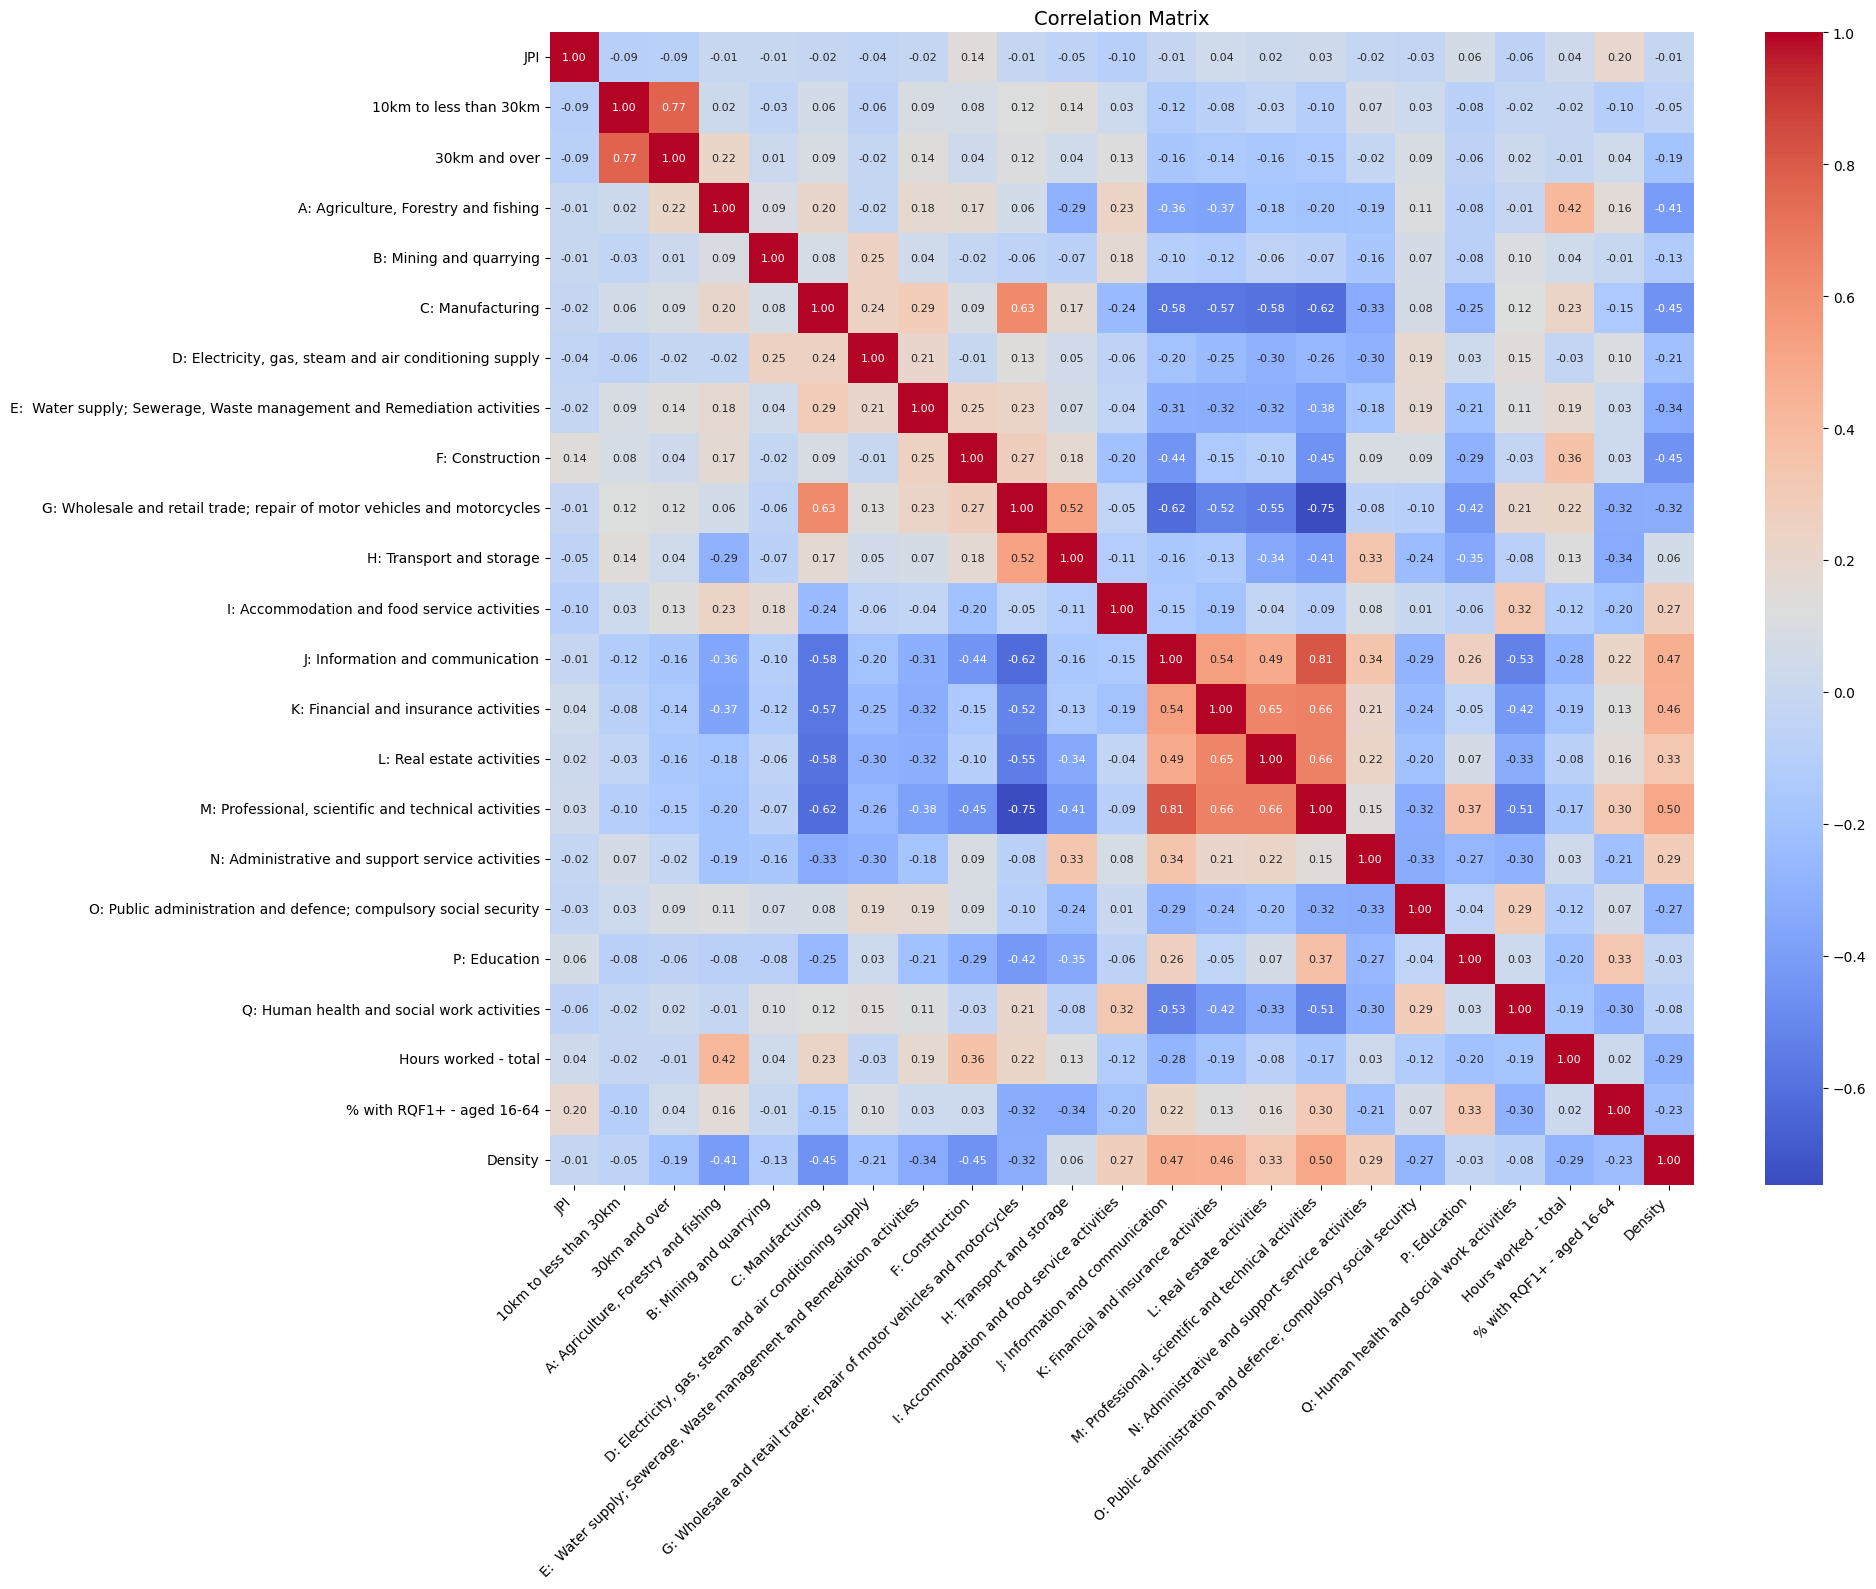

In [146]:
import seaborn as sns
import matplotlib.pyplot as plt

# 假设x_cols是解释变量列列表，gdf_ols是GeoDataFrame
plt.figure(figsize=(20, 16))  # 增大画布尺寸
corr_matrix = gdf_ols[X_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            annot_kws={"size": 8},  # 调整注解字体大小
            xticklabels=True, yticklabels=True)
plt.xticks(rotation=45, ha='right', fontsize=10)  # 旋转x轴标签，避免重叠
plt.yticks(rotation=0, fontsize=10)  # y轴标签水平
plt.title('Correlation Matrix', fontsize=14)
plt.tight_layout()  # 自动调整布局
plt.show()

### 清理相关性高的变量

In [147]:
#10km to less than 30km 与 30km and over合并成10km and over
#Q: Human health and social work activities 与 P: Education合并成Public Education and Welfare Services
#M: Professional, scientific and technical activities ，J: Information and communication与 K: Financial and insurance activities合并成Technology and Financial Services
#只保留最高教育等级

gdf_ols['10km and over'] = gdf_ols['10km to less than 30km'] + gdf_ols['30km and over']
gdf_ols['Public Education and Welfare Services'] = gdf_ols['Q: Human health and social work activities'] + gdf_ols['P: Education']
gdf_ols['Technology and Financial Services'] = (
    gdf_ols['M: Professional, scientific and technical activities'] +
    gdf_ols['J: Information and communication'] +
    gdf_ols['K: Financial and insurance activities']
)

#重新定义X_cols
to_remove = [
    '10km to less than 30km', '30km and over',
    'Q: Human health and social work activities', 'P: Education',
    'M: Professional, scientific and technical activities', 'J: Information and communication', 'K: Financial and insurance activities'
]
new_cols = [
    '10km and over',
    'Public Education and Welfare Services',
    'Technology and Financial Services'
]
X_cols = [col for col in X_cols if col not in to_remove] + new_cols
print(X_cols)

['JPI', 'A: Agriculture, Forestry and fishing', 'B: Mining and quarrying', 'C: Manufacturing', 'D: Electricity, gas, steam and air conditioning supply', 'E:  Water supply; Sewerage, Waste management and Remediation activities', 'F: Construction', 'G: Wholesale and retail trade; repair of motor vehicles and motorcycles', 'H: Transport and storage', 'I: Accommodation and food service activities', 'L: Real estate activities', 'N: Administrative and support service activities', 'O: Public administration and defence; compulsory social security', 'Hours worked - total', '% with RQF1+ - aged 16-64', 'Density', '10km and over', 'Public Education and Welfare Services', 'Technology and Financial Services']


f:\Python 3.13\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
f:\Python 3.13\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
f:\Python 3.13\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

### AI暴露度与人口密度散点图

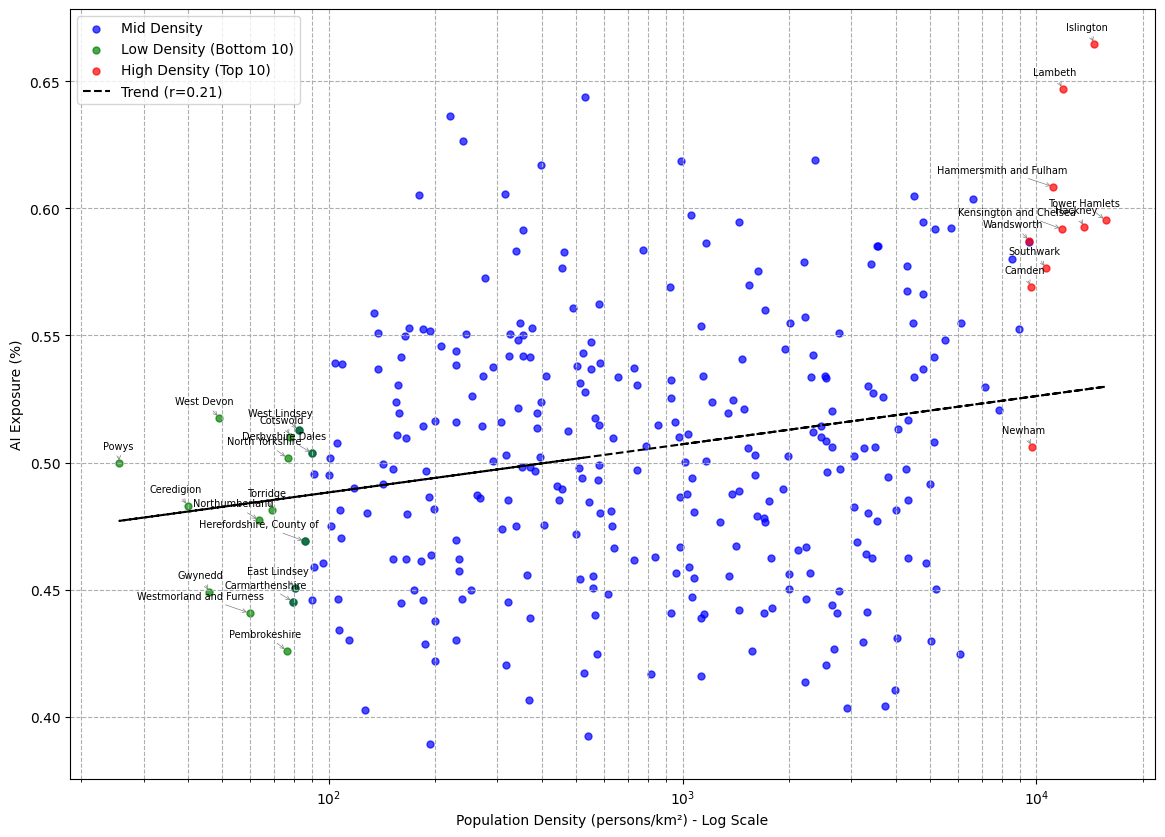

In [148]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

density = gdf_ols['Density'].values[density > 0]
exposure = gdf_ols['avg_ai_exposure'].values[density > 0]
cities = gdf_ols['LAD25NM'].values[density > 0]

sorted_idx = np.argsort(density)
low_idx, high_idx = sorted_idx[:15], sorted_idx[-10:]
mid_idx = sorted_idx[10:-10] if len(sorted_idx) > 20 else []

fig, ax = plt.subplots(figsize=(14, 10))
if len(mid_idx): ax.scatter(density[mid_idx], exposure[mid_idx], c='blue', s=25, alpha=0.7, label='Mid Density')
ax.scatter(density[low_idx], exposure[low_idx], c='green', s=25, alpha=0.7, label='Low Density (Bottom 10)')
ax.scatter(density[high_idx], exposure[high_idx], c='red', s=25, alpha=0.7, label='High Density (Top 10)')

for i in np.concatenate([low_idx, high_idx]):
    ax.annotate(cities[i], (density[i], exposure[i]), xytext=(10, 10), textcoords='offset points', ha='right', fontsize=7, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))

ax.set_xlabel('Population Density (persons/km²) - Log Scale')
ax.set_ylabel('AI Exposure (%)')
ax.set_xscale('log')
ax.grid(True, which='both', ls='--', color='#ABAEAE')

log_dens = np.log10(density)
slope, intercept, r, _, _ = linregress(log_dens, exposure)
ax.plot(density, slope * log_dens + intercept, 'k--', label=f'Trend (r={r:.2f})')

ax.legend()
plt.show()

### AI暴露度与职业人数

C:\Users\uiol\AppData\Local\Temp\ipykernel_22196\3455814845.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(labels, rotation=0)


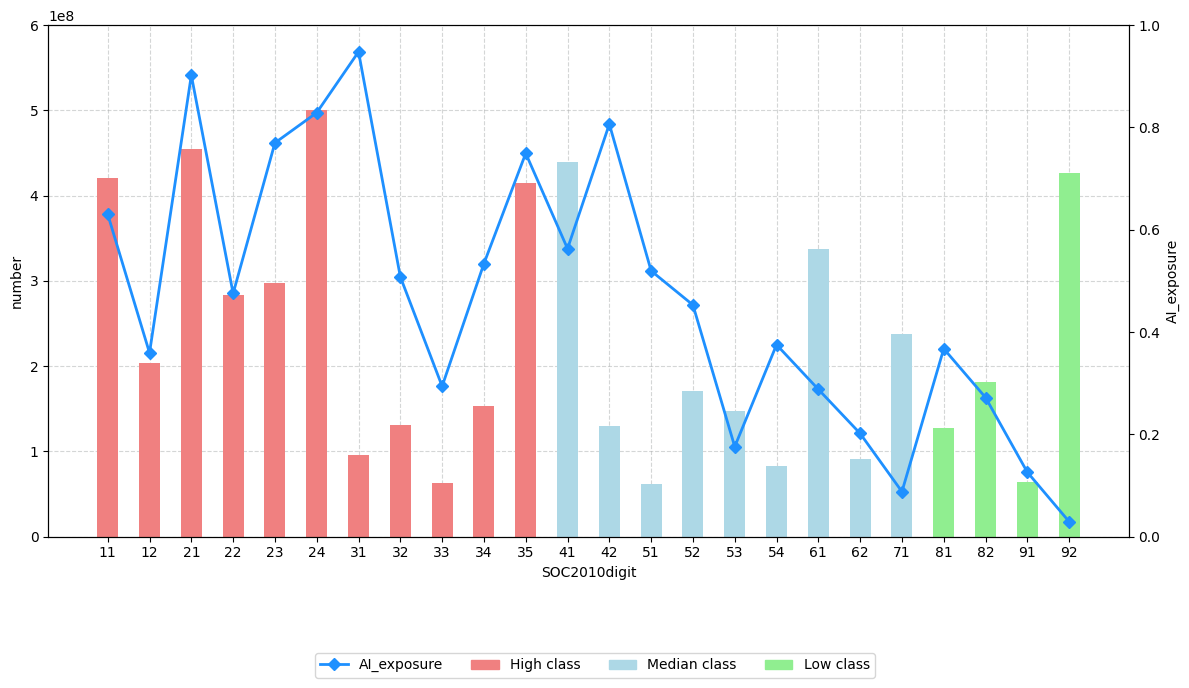

In [149]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle

labels = ['11', '12', '21', '22', '23', '24', '31', '32', '33', '34', '35', '41', '42', '51', '52', '53', '54', '61', '62', '71', '81', '82', '91', '92']
ai_exposure = [0.6302, 0.3593, 0.902, 0.4754, 0.7698, 0.8288, 0.9478, 0.508, 0.294, 0.5338, 0.7494, 0.563, 0.8065, 0.5196, 0.4529, 0.176, 0.3752, 0.288, 0.2017, 0.088, 0.3674, 0.272, 0.126, 0.0293]
numbers = [420611148, 203389696, 454953091, 283574893, 297379083, 500357231, 96257073, 130969381, 63075782, 152796215, 414430936, 438984964, 129982194, 61557721, 171370631, 147263335, 82372387, 337342251, 91624603, 238210813, 127977284, 181793830, 64006433, 426710806]
classes = ['high'] * 11 + ['median'] * 9 + ['low'] * 4

color_map = {'high': 'lightcoral', 'median': 'lightblue', 'low': 'lightgreen'}
bar_colors = [color_map[cls] for cls in classes]

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.set_axisbelow(True)
ax1.grid(linestyle='--', alpha=0.5, color='#ABAEAE')

ax1.bar(labels, numbers, color=bar_colors, width=0.5)
ax1.set_ylabel('number')
ax1.set_ylim(0, 600000000)
ax1.set_xlabel('SOC2010digit')

ax2 = ax1.twinx()
ax2.plot(labels, ai_exposure, color='dodgerblue', linewidth=2, marker='D')
ax2.set_ylabel('AI_exposure')
ax2.set_ylim(0, 1)

ax1.set_xticklabels(labels, rotation=0)

legend_elements = [Line2D([0], [0], color='dodgerblue', lw=2, marker='D', label='AI_exposure')]
for cls in ['high', 'median', 'low']:
    legend_elements.append(Rectangle((0, 0), 1, 1, color=color_map[cls], label=cls.capitalize() + ' class'))

fig.legend(handles=legend_elements, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.15))

plt.tight_layout()
plt.show()

In [150]:
rename_dict = {
    'JPI': 'JPI',
    '10km and over': 'Commuting 10 kilometers or more',
    '10km to less than 30km': 'Commuting 10 to less than 30 kilometers',
    '30km and over': 'Commuting 30 kilometers or more',
    'Works mainly from home': 'Working from home',
    'Less than 10km': 'Commuting less than 10 kilometers',
    'A: Agriculture, Forestry and fishing': 'Agriculture, Forestry and fishing',
    'B: Mining and quarrying': 'Mining and quarrying',
    'C: Manufacturing': 'Manufacturing',
    'D: Electricity, gas, steam and air conditioning supply': 'Electricity, gas, steam and air conditioning supply',
    'E:  Water supply; Sewerage, Waste management and Remediation activities': 'Water supply; Sewerage, Waste management and Remediation activities',
    'F: Construction': 'Construction',
    'G: Wholesale and retail trade; repair of motor vehicles and motorcycles': 'Wholesale and retail trade; repair of motor vehicles and motorcycles',
    'H: Transport and storage': 'Transport and storage',
    'I: Accommodation and food service activities': 'Accommodation and food service activities',
    'L: Real estate activities': 'Real estate activities',
    'N: Administrative and support service activities': 'Administrative and support service activities',
    'O: Public administration and defence; compulsory social security': 'Public administration and defence; compulsory social security',
    'R, S, T, U Other': 'Other',
    'Weekly pay - gross': 'Gross pay per week',
    'Hours worked - total': 'Work hours per week',
    '% aged 16-64 who are self employed': 'Self-employed - aged 16-64',
    '% with RQF1+ - aged 16-64': 'RQF1+ - aged 16-64',
    '% with RQF2+ - aged 16-64': 'RQF2+ - aged 16-64',
    '% with RQF3+ - aged 16-64': 'RQF3+ - aged 16-64',
    '% with RQF4+ - aged 16-64': 'RQF4+ - aged 16-64',
    'Aged 16 to 24 years': 'Aged 16-24',
    'Aged 25 to 34 years': 'Aged 25-34',
    'Aged 35 to 49 years': 'Aged 35-49',
    'Aged 50 to 64 years': 'Aged 50-64',
    'Aged 65 years and over': 'Aged 65 and over',
    'Density': 'Population density'
}

gdf_ols = gdf_ols.rename(columns=rename_dict)
print(gdf_ols.columns)

Index(['LAD25CD', 'LAD25NM', 'LAD25NMW', 'BNG_E', 'BNG_N', 'LONG', 'LAT',
       'GlobalID', 'Area', 'geometry', 'avg_ai_exposure',
       'Commuting 10 to less than 30 kilometers',
       'Commuting 30 kilometers or more', 'Commuting less than 10 kilometers',
       'Working from home', 'Agriculture, Forestry and fishing',
       'Mining and quarrying', 'Manufacturing',
       'Electricity, gas, steam and air conditioning supply',
       'Water supply; Sewerage, Waste management and Remediation activities',
       'Construction',
       'Wholesale and retail trade; repair of motor vehicles and motorcycles',
       'Transport and storage', 'Accommodation and food service activities',
       'J: Information and communication',
       'K: Financial and insurance activities', 'Real estate activities',
       'M: Professional, scientific and technical activities',
       'Administrative and support service activities',
       'Public administration and defence; compulsory social security',

In [152]:
#重新定义X_cols
X_cols=['JPI',
       # 'Commuting 10 to less than 30 kilometers','Commuting 30 kilometers or more', 'Commuting less than 10 kilometers','Working from home', 
       'Commuting 10 kilometers or more',
       # 'Gross pay per week', 
       'Work hours per week', 
       # 'Self-employed - aged 16-64',
       'RQF1+ - aged 16-64', 
       # 'RQF2+ - aged 16-64', 'RQF3+ - aged 16-64','RQF4+ - aged 16-64', 
       # 'Aged 15 years and under', 'Aged 16-24','Aged 25-34', 'Aged 35-49', 'Aged 50-64', 'Aged 65 and over', 
       'Population density',
       'Agriculture, Forestry and fishing',
       'Mining and quarrying', 'Manufacturing',
       'Public Education and Welfare Services',
       'Technology and Financial Services',       
       'Electricity, gas, steam and air conditioning supply',
       'Water supply; Sewerage, Waste management and Remediation activities',
       'Construction',
       'Wholesale and retail trade; repair of motor vehicles and motorcycles',
       'Transport and storage', 'Accommodation and food service activities',
       'Administrative and support service activities',
       'Public administration and defence; compulsory social security','Other',]

## 空间自相关性判断

### 反距离权重(因变量)

f:\Python 3.13\Lib\site-packages\scipy\sparse\_data.py:128: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)


Moran's I: 0.350418
Expected I: -0.003195
z-score: 25.060535
p-value (norm): 0.000000
p-value (perm): 0.001000


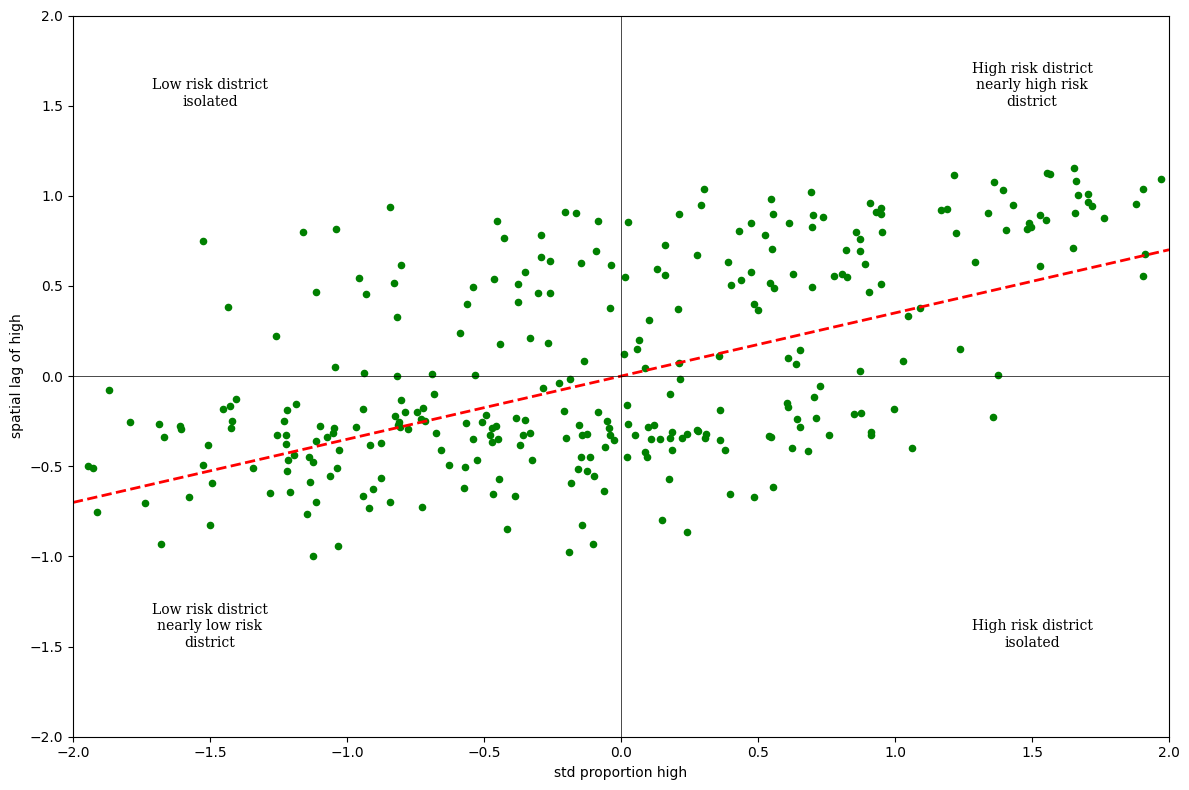

In [153]:
import numpy as np
from libpysal.weights import DistanceBand
from libpysal.weights.spatial_lag import lag_spatial
from esda.moran import Moran
import matplotlib.pyplot as plt

coords = list(zip(gdf_ols.geometry.centroid.x, gdf_ols.geometry.centroid.y))
W_idw = DistanceBand(coords, threshold=90773.1659, alpha=-1.0, binary=False, silence_warnings=True)
W_idw.transform = 'r'

y = gdf_ols['avg_ai_exposure'].values.reshape(-1, 1)

moran = Moran(y, W_idw, permutations=999, two_tailed=False)

print("="*50)
print(f"Moran's I: {moran.I:.6f}")
print(f"Expected I: {moran.EI:.6f}")
print(f"z-score: {moran.z_norm:.6f}")
print(f"p-value (norm): {moran.p_norm:.6f}")
print(f"p-value (perm): {moran.p_sim:.6f}")
print("="*50)

z = (y - y.mean()) / y.std()
lag_z = lag_spatial(W_idw, z)

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(z, lag_z, color='green', s=20)

slope = moran.I
ax.plot([-2, 2], [slope * -2, slope * 2], color='red', linewidth=2, linestyle='--')

ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)

ax.set_xlabel('std proportion high')
ax.set_ylabel('spatial lag of high')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)

ax.text(-1.5, -1.5, 'Low risk district\nnearly low risk\ndistrict', color='black', fontsize=10, ha='center', family='serif')
ax.text(-1.5, 1.5, 'Low risk district\nisolated', color='black', fontsize=10, ha='center', family='serif')
ax.text(1.5, -1.5, 'High risk district\nisolated', color='black', fontsize=10, ha='center', family='serif')
ax.text(1.5, 1.5, 'High risk district\nnearly high risk\ndistrict', color='black', fontsize=10, ha='center', family='serif')

plt.tight_layout()

plt.show()

你的 AI 暴露度在英国地区有非常强的空间聚集性（正空间自相关）。

高暴露度地区往往挨着高暴露度地区，低暴露度地区也倾向于彼此相邻。

这种聚集模式几乎不可能由随机分布产生（p≈0）。

后续可以用 LISA 聚类图 把 High-High、Low-Low、High-Low、Low-High 的空间格局画出来，这样可以直观看到“核心—边缘”模式。

### 反距离权重(自变量)

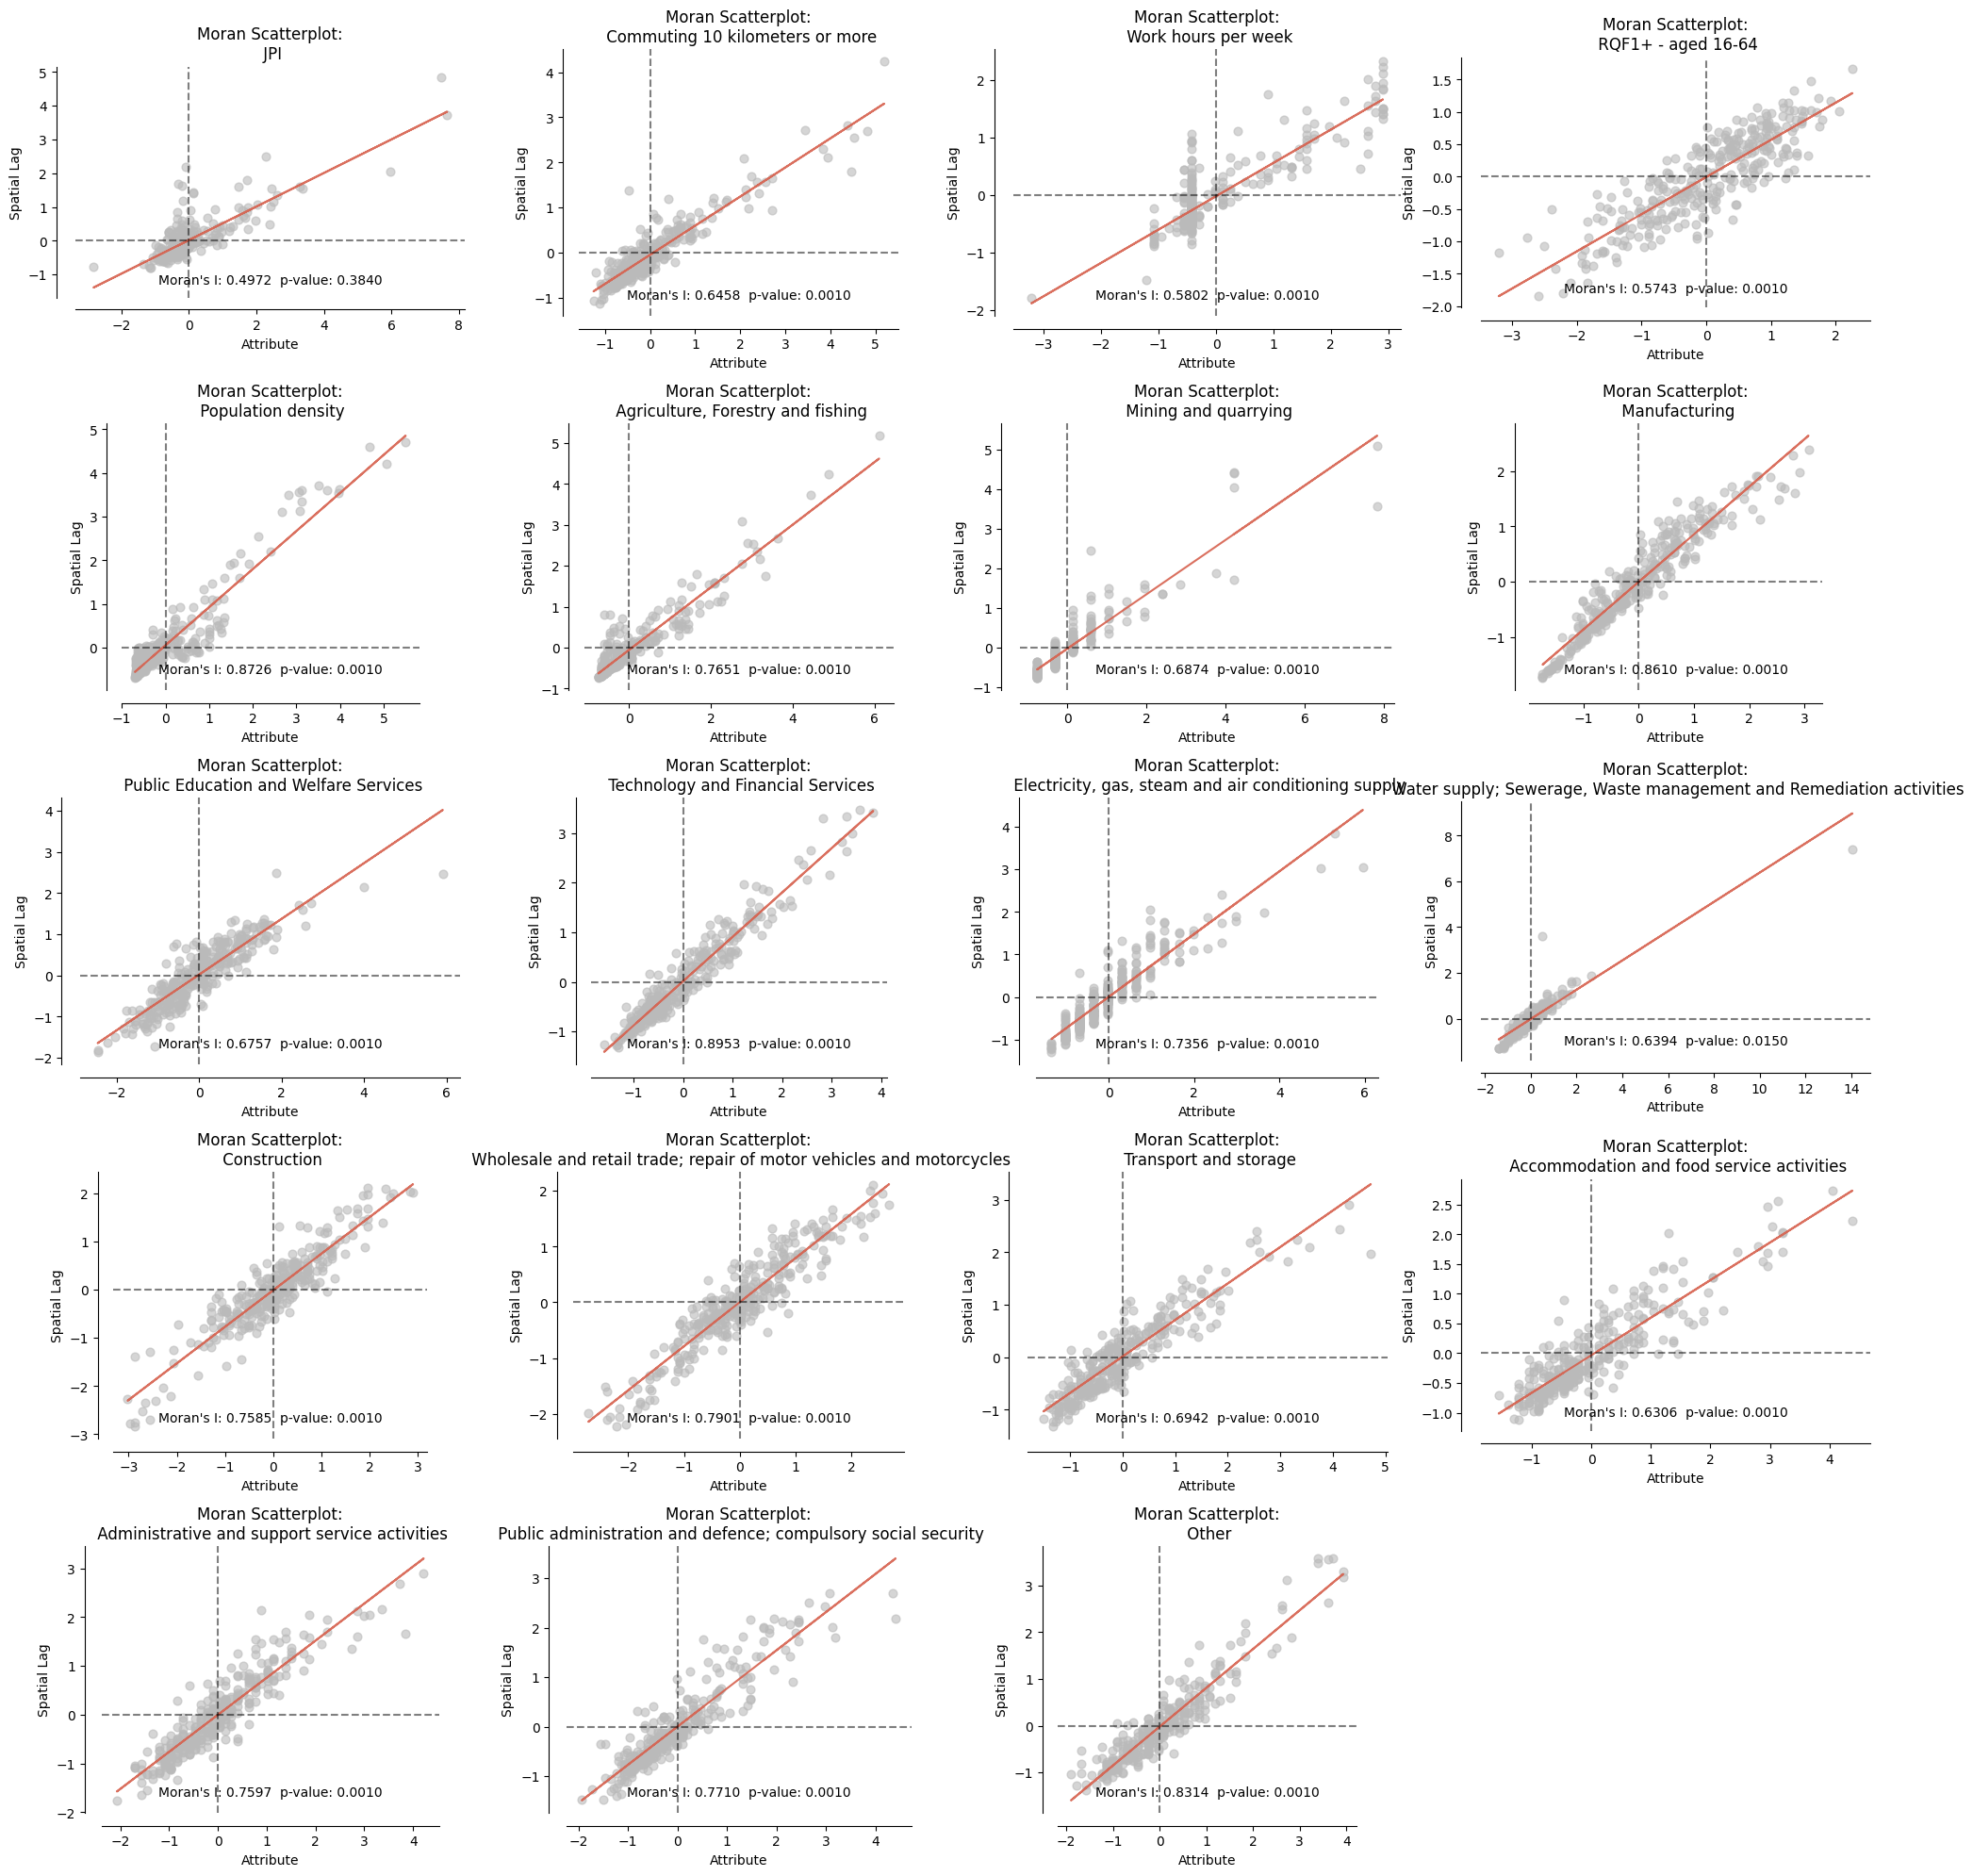

In [170]:
import geopandas as gpd
import libpysal as lps
import esda
import splot.esda as splot_esda
import matplotlib.pyplot as plt
import numpy as np

numeric_cols = [col for col in X_cols if gdf_ols[col].dtype in [np.float64, np.int64]]

coords = np.array(list(zip(gdf_ols.geometry.centroid.x, gdf_ols.geometry.centroid.y)))
w_idw = lps.weights.Kernel(coords, fixed=False, function='triangular', k=5)
w_idw.transform = 'r'

n = len(numeric_cols)
nrows = int(np.ceil(np.sqrt(n)))
ncols = int(np.ceil(n / nrows))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))
axes = axes.flatten()

for i, var in enumerate(numeric_cols):
    y = gdf_ols[var].values
    moran = esda.Moran(y, w_idw)
    
    splot_esda.moran_scatterplot(moran, ax=axes[i])
    axes[i].set_title(f"Moran Scatterplot:\n {var}")
    axes[i].text(0.5, 0.05, f"Moran's I: {moran.I:.4f}  p-value: {moran.p_sim:.4f}", transform=axes[i].transAxes, ha='center', va='bottom')

for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

### 几何邻接关系Queen

In [155]:
import numpy as np
import libpysal

# 方法1：基于几何邻接关系

# 构建 Queen 权重矩阵
queen_w = libpysal.weights.Queen.from_dataframe(gdf_ols)  # 默认基于几何边界
queen_w.transform = 'r'  # 行标准化（推荐）

# 检查孤岛（无邻居的区域）
isolated = np.where(np.array([len(queen_w.neighbors[i]) for i in range(queen_w.n)]) == 0)[0]
print(f"孤岛数量：{len(isolated)}，索引：{isolated}")

# 剔除孤岛（可选）
if len(isolated) > 0:
    mask = np.ones(queen_w.n, dtype=bool)
    mask[isolated] = False
    gdf_ols = gdf_ols.iloc[mask]
    queen_w_clean = libpysal.weights.Queen.from_dataframe(gdf_ols)
else:
    queen_w_clean = queen_w    

C:\Users\uiol\AppData\Local\Temp\ipykernel_22196\2878055746.py:7: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  queen_w = libpysal.weights.Queen.from_dataframe(gdf_ols)  # 默认基于几何边界
f:\Python 3.13\Lib\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 43, 292.
  W.__init__(self, neighbors, ids=ids, **kw)
C:\Users\uiol\AppData\Local\Temp\ipykernel_22196\2878055746.py:19: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  queen_w_clean = libpysal.weights.Queen.from_dataframe(gdf_ols)


('WARNING: ', 43, ' is an island (no neighbors)')
('WARNING: ', 292, ' is an island (no neighbors)')
孤岛数量：2，索引：[ 43 292]


## 建模

### OLS建模

In [156]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from spreg import OLS
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV

# (1) 准备变量

# 转换为浮点型
X_df = gdf_ols[X_cols].astype(float)

# 添加常数项（保持为 DataFrame）
X = sm.add_constant(X_df)

# 因变量
Y = np.array(gdf_ols['avg_ai_exposure'], dtype=float).reshape(-1, 1)

# Ridge 回归（自动交叉验证调参）
# 标准化
scaler = StandardScaler()
X_scaled_R = scaler.fit_transform(X)


# 转换为 NumPy 数组用于 OLS（仅在必要时）
X = np.array(X, dtype=float)
# 生成自变量名称列表
name_x = ['const'] + X_cols

# 运行 OLS 回归
ols = OLS(
    name_ds="gdf_ols",
    name_w=queen_w_clean,
    y=Y,
    x=X,
    w=queen_w_clean,  # 必须提供权重矩阵
    name_y="avg_ai_exposure",  # 明确因变量名
    name_x=name_x,    # 使用筛选后的自变量名
    moran=True,
    spat_diag=True,
    robust='white'  # 使用稳健标准误处理异方差
)

# 打印 OLS 结果
print("============")
print("\nOLS 回归摘要")
print(ols.summary)




OLS 回归摘要
REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     gdf_ols
Weights matrix      :<libpysal.weights.contiguity.Queen object at 0x00000200ADEDE750>
Dependent Variable  :avg_ai_exposure                Number of Observations:         312
Mean dependent var  :      0.5053                Number of Variables   :          20
S.D. dependent var  :      0.0527                Degrees of Freedom    :         292
R-squared           :      0.7019
Adjusted R-squared  :      0.6825
Sum squared residual:     0.25722                F-statistic           :     36.1854
Sigma-square        :       0.001                Prob(F-statistic)     :   2.511e-65
S.E. of regression  :       0.030                Log likelihood        :     665.020
Sigma-square ML     :       0.001                Akaike info criterion :   -1290.040
S.E of regression ML:      0.0287                Schwarz criterion     :   -1215.

### 多重共线性与异方差检验：VIF、Breusch–Pagan test

In [157]:
from statsmodels.stats.diagnostic import het_breuschpagan

# 计算 VIF 报告
# 确保 X_selected_array 有列名，转换为 DataFrame 以匹配
X_selected_df = pd.DataFrame(X, columns=name_x)
vif_data = pd.DataFrame()
vif_data["Variable"] = X_selected_df.columns
vif_data["VIF"] = [variance_inflation_factor(X_selected_df.values, i) 
for i in range(X_selected_df.shape[1])]
print("VIF 报告：")
print(vif_data.sort_values(by="VIF", ascending=False).to_string(index=False))

# 1. 首先获取模型的残差
residuals = ols.u  # pysal OLS模型的残差存储在u属性中
print(f"残差获取完成，长度：{len(residuals)}")
# 2. 准备解释变量矩阵（与原始模型相同）
exog = X
print(f"解释变量矩阵准备完成，形状：{exog.shape}")
# 3. 执行Breusch-Pagan检验
bp_test = het_breuschpagan(residuals, exog)
# 4. 输出结果
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
bp_results = dict(zip(labels, bp_test))
print("Breusch-Pagan 检验结果：")
for label, value in bp_results.items():
    print(f"{label}: {value:.4f}")

VIF 报告：
                                                            Variable           VIF
                                                               const 125640.064556
                                   Technology and Financial Services    520.798424
                                                       Manufacturing    116.252051
                               Public Education and Welfare Services    109.581015
Wholesale and retail trade; repair of motor vehicles and motorcycles     71.718517
                                                        Construction     48.045257
       Public administration and defence; compulsory social security     43.386318
                                               Transport and storage     32.672249
                                   Agriculture, Forestry and fishing     22.597319
                           Accommodation and food service activities     19.513688
                                                               Other     14.624

### LMlag 和 LMerr 检验

In [158]:

print("="*50)
print("\nRobust LM Error Test:")
print(f"Statistic: {ols.rlm_error}")
print(f"P-value: {ols.rlm_error}")
print("\nRobust LM Lag Test:")
print(f"Statistic: {ols.rlm_lag}")
print(f"P-value: {ols.rlm_lag}")
print(f"\nMoran’s I of the residuals is {round(ols.moran_res[0],3)}")
print(f"standardized value is {round(ols.moran_res[1],3)}")
print(f"p-value is {round(ols.moran_res[2],4)}")
print("="*50)



Robust LM Error Test:
Statistic: (np.float64(1.750607828251525), np.float64(0.185800338136333))
P-value: (np.float64(1.750607828251525), np.float64(0.185800338136333))

Robust LM Lag Test:
Statistic: (np.float64(18.95191272216065), np.float64(1.3405481826877802e-05))
P-value: (np.float64(18.95191272216065), np.float64(1.3405481826877802e-05))

Moran’s I of the residuals is 0.066
standardized value is 2.537
p-value is 0.0112


### 空间滞后模型

Moran’s I 测试用于检测残差的空间自相关。Moran’s I = -0.028（接近 0），p-value = 0.9101 >> 0.05，表明残差没有显著的空间自相关。这与 Robust LM Error Test 的结果一致，说明残差在空间上分布较为随机，当前 OLS 模型在空间误差方面表现良好。然而，这并不否定 Robust LM Lag Test 检测到的空间滞后效应，因为 Moran’s I 主要关注残差的空间模式，而非因变量的滞后效应。
Robust LM Error Test 用于检测是否存在空间误差自相关（spatial error autocorrelation）。p-value = 0.3093 > 0.05，表明没有显著的证据支持存在空间误差自相关。因此，模型的残差在空间误差方面没有显著问题，当前的 OLS 模型可能不需要引入空间误差项（spatial error model）。
Robust LM Lag Test 用于检测是否存在空间滞后效应（spatial lag dependence），即因变量是否受到邻近区域因变量的影响。p-value = 0.0125 < 0.05，表明存在显著的空间滞后效应。这建议你的模型可能需要考虑空间滞后模型（spatial lag model，例如 spreg.ML_Lag 或 spreg.GM_Lag），以纳入邻近区域的因变量影响。
OLS 模型残差中没有“误差空间结构”，但因变量存在 显著空间滞后效应，应使用 SAR 模型（空间滞后模型）

In [159]:
from spreg import ML_Lag

# 4. 运行 slm 模型
slm1 = ML_Lag(    
    name_ds="gdf_ols",
    y=Y,
    x=X,
    w=queen_w_clean,
    name_y="avg_ai_exposure",
    name_x=name_x,
    name_w=queen_w_clean,
    robust='white'
)
print("=== SLM 模型结果 ===")
print(slm1.summary)

print("\n=== 模型比较  ===")
print(f"OLS AIC : {ols.aic}")
print(f"SLM AIC : {slm1.aic}")



f:\Python 3.13\Lib\site-packages\spreg\ml_lag.py:710: RuntimeWarning: invalid value encountered in log
  jacob = np.log(np.linalg.det(a))


=== SLM 模型结果 ===
REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     gdf_ols
Weights matrix      :<libpysal.weights.contiguity.Queen object at 0x00000200ADEDE750>
Dependent Variable  :avg_ai_exposure                Number of Observations:         312
Mean dependent var  :      0.5053                Number of Variables   :          21
S.D. dependent var  :      0.0527                Degrees of Freedom    :         291
Pseudo R-squared    :      0.7210
Spatial Pseudo R-squared:  0.7203
Log likelihood      :    675.3097
Sigma-square ML     :      0.0008                Akaike info criterion :   -1308.619
S.E of regression   :      0.0278                Schwarz criterion     :   -1230.016

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Pro

SAR 的 AIC (-1319.2854) 低于 OLS 的 AIC (-1315.4129)，表明 SAR 模型的拟合优于 OLS 模型。
差值约为 -3.8725，虽然改进幅度不大，但仍表明 SAR 模型更好地捕捉了数据的空间结构。
SAR 模型的改进（较低 AIC）表明空间滞后项比单纯依赖自变量（包括年龄分组字段）更能解释因变量的变异。

### 空间杜宾模型加上WX项

In [160]:
from spreg import ML_Lag

# 4. 运行 slm 模型（加入 WX 项）
slm2 = ML_Lag(    
    name_ds="gdf_ols",
    y=Y,
    x=X,
    w=queen_w_clean,
    slx_lags=1,  # 加入 WX 项（空间滞后解释变量）
    slx_vars='All',  # 对所有解释变量计算空间滞后（默认值，可省略）
    name_y="avg_ai_exposure",
    name_x=name_x,
    name_w="queen_w_clean",  # 权重矩阵名称（字符串）
    robust='white',  # 使用 White 稳健标准误
    spat_diag=True,  # 计算空间诊断（如 Common Factor Hypothesis 检验）
    spat_impacts='simple'  # 计算空间效应分解（直接、间接、总效应）
)
print("=== SAR 模型结果（含 WX 项）===")
print(slm2.summary)

print("\n=== 模型比较  ===")
print(f"OLS AIC : {ols.aic}")
print(f"SAR AIC : {slm2.aic}")

=== SAR 模型结果（含 WX 项）===
REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG WITH SLX - SPATIAL DURBIN MODEL (METHOD = FULL)
-------------------------------------------------------------------------------------------------
Data set            :     gdf_ols
Weights matrix      :queen_w_clean
Dependent Variable  :avg_ai_exposure                Number of Observations:         312
Mean dependent var  :      0.5053                Number of Variables   :          40
S.D. dependent var  :      0.0527                Degrees of Freedom    :         272
Pseudo R-squared    :      0.7486
Spatial Pseudo R-squared:  0.7486
Log likelihood      :    691.5855
Sigma-square ML     :      0.0007                Akaike info criterion :   -1303.171
S.E of regression   :      0.0264                Schwarz criterion     :   -1153.451

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error    

f:\Python 3.13\Lib\site-packages\spreg\ml_lag.py:710: RuntimeWarning: invalid value encountered in log
  jacob = np.log(np.linalg.det(a))


### 空间误差模型

In [161]:
from spreg import ML_Error

sem = ML_Error(    
    name_ds="gdf_ols",
    y=Y,
    x=X,
    w=queen_w_clean,
    name_y="avg_ai_exposure",
    name_x=name_x,
    name_w=queen_w_clean,
    robust='white'
)
print("=== SEM 模型结果 ===")
print(sem.summary)

print("\n=== 模型比较  ===")
print(f"OLS AIC : {ols.aic}")
print(f"SEM AIC : {sem.aic}")

f:\Python 3.13\Lib\site-packages\spreg\ml_error.py:184: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  res = minimize_scalar(
f:\Python 3.13\Lib\site-packages\spreg\ml_error.py:563: RuntimeWarning: invalid value encountered in log
  jacob = np.log(np.linalg.det(a))


=== SEM 模型结果 ===
REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ML SPATIAL ERROR (METHOD = full)
---------------------------------------------------
Data set            :     gdf_ols
Weights matrix      :<libpysal.weights.contiguity.Queen object at 0x00000200ADEDE750>
Dependent Variable  :avg_ai_exposure                Number of Observations:         312
Mean dependent var  :      0.5053                Number of Variables   :          20
S.D. dependent var  :      0.0527                Degrees of Freedom    :         292
Pseudo R-squared    :      0.7000
Log likelihood      :    667.2103
Sigma-square ML     :      0.0008                Akaike info criterion :   -1294.421
S.E of regression   :      0.0284                Schwarz criterion     :   -1219.560

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------------------------------